STUDENT = UFUK CEM BIRBIRI

###tools.py

In [91]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import minimize
from scipy.stats import norm, uniform, binom
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal

def laplace_solution(params, other_params, data, lik, priors):
  
    def evaluate_log_post(params, other_params, data, lik, priors):
        model_list = { 'gaussian' : norm, 'uniform': uniform, 'binomial' : binom}
    
        model_lik = model_list[lik]
    
        #Computing log-priors
        log_prior = 0
        for i,mod in enumerate(priors):
            log_prior += model_list[mod[0]].logpdf(params[i], *mod[1])

            
        #Computing log-likelihood
        if lik == 'gaussian':
            # Dirty trick for guaranteeing positive variance
            params[-1] = np.abs(params[-1])
                
        if len(other_params)>0:
            log_lik = np.sum([model_list[lik].logpdf(point, *(params,other_params)) for point in data])
        else:
            log_lik = np.sum([model_list[lik].logpdf(point, *params) for point in data])
        return - (log_lik + log_prior)
    
    minimum =  minimize(evaluate_log_post, params,  
                        args = (other_params, data, lik, priors), method = 'BFGS')
    print(minimum)
    return [minimum.x, minimum.hess_inv]


def laplace_solution_regression(expression, data, lik, priors):
    model_list = { 'gaussian' : norm, 'uniform': uniform, 'binomial' : binom}
    
    def evaluate_log_post(params, var_names, data, lik, priors):
        model_list = { 'gaussian' : norm, 'uniform': uniform, 'binomial' : binom}
        model_lik = model_list[lik]
    
        #Computing log-priors
        log_prior = 0
        for i,mod in enumerate(priors):
            log_prior += model_list[mod[0]].logpdf(params[i], *mod[1])

        #Evaluating expression
        target, predictors = var_names[0], var_names[1]
        
        mu = np.ones(len(data[predictors[0]])) * params[0]
        
        for i in range(len(predictors)):
            mu += params[i+1] * data[predictors[i]].values
            
        sigma = np.abs(params[-1])
        
        t = data[target].values
        N = len(t)
               
        log_lik = np.sum([model_list['gaussian'].logpdf(t[i], mu[i], sigma) for i in range(N)])
        return -(log_lik + log_prior)
    
    collapsed_expression = expression.replace(" ", "")
    target, independent = collapsed_expression.split('~') 
    independent = independent.split('+')
    var_names = [target, independent]
    
    params = []
    for i in range(len(priors)):
        params.append(model_list[priors[i][0]].rvs(*priors[i][1]))
    
    minimum =  minimize(evaluate_log_post, params, args = (var_names, data, lik, priors), method = 'BFGS')
    print(minimum)
    return [minimum.x, minimum.hess_inv]

def post_sample_Laplace(solution, N_sample):
    posterior_samples = multivariate_normal.rvs(solution[0], solution[1], size = N_sample)
    return posterior_samples

def posterior_stats(solution, names, plot = False):
    posterior_samples = post_sample_Laplace(solution, 1000)
    post_quantiles = np.quantile(posterior_samples, q = [0.075, 0.925], axis = 0)
    # sd
    post_sd = np.std(posterior_samples, axis = 0)
    # mean
    post_mean = np.mean(posterior_samples, axis = 0)
    summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]
    summary_stats = pd.DataFrame(summary_stats).transpose()
    summary_stats.columns = ['mean', 'SD', '7.5%', '92.5%']
    summary_stats.index = names
    #summary_stats.rename(index=list(names), inplace=True)
    print(summary_stats)
    if plot:
        boxes = []
        for i in range(len(post_mean)):
            boxes.append(posterior_samples[:,i])
        plt.boxplot(boxes,vert=0)
        plt.yticks(range(len(post_mean)+1)[1:], names)
        plt.axvline(x=0, color = 'black', alpha = 0.1)
        plt.show()

def posterior_plot_univariate_regression(solution, x_range, data, center = 0, names = ['x','y'], N_samples = 500):
    post_samples = post_sample_Laplace(solution, N_samples)
    degree = post_samples.shape[1] - 1

    post_mean = np.mean(post_samples, axis = 0)

    mean_prediction = np.zeros(len(x_range))
    for i in range(degree):
        mean_prediction += post_mean[i] * x_range**i 

    plt.plot(x_range + center, mean_prediction, lw = 2, color = 'black')
    plt.title('regression result')
    plt.ylabel(names[1])
    plt.xlabel(names[0])

    list_model_samples = []
    #sampling from the posterior to get a predictive interval
    for n in range(N_samples):
        mod_sample = np.zeros(len(x_range))
        for i in range(degree):
            mod_sample += post_samples[n,i] * x_range**i
        list_model_samples.append(mod_sample)

    prediction_noise = []
    for i,mod_sample in enumerate(list_model_samples):
        prediction_noise.append(norm.rvs( mod_sample, post_samples[i,-1]))  

    # Plotting the uncertainty
    for i in range(N_samples): 
        plt.scatter(x_range + center, prediction_noise[i], alpha = 0.05, color = 'grey')
        plt.scatter(x_range + center, list_model_samples[i], alpha = 0.05, color = 'green')

    plt.scatter( data[names[0]] + center, data[names[1]])
 


## Exercise 1

Consider the following bivariate distribution:

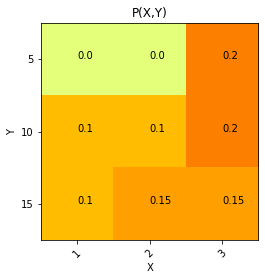

In [45]:
import matplotlib.pyplot as plt
import numpy as np

freq = [[0.,0.,0.2],[0.1,0.1,0.2],[0.1,0.15,0.15]]

plt.clf()
plt.imshow(freq, interpolation='nearest', cmap=plt.cm.Wistia)
X_values = ['1','2','3']
Y_values = ['5','10','15']
plt.ylabel('Y')
plt.xlabel('X') 
plt.title('P(X,Y)') 
plt.xticks(np.arange(len(X_values)), X_values, rotation=45)
plt.yticks(np.arange(len(Y_values)), Y_values)
for i in range(len(X_values)):
    for j in range(len(Y_values)):
        plt.text(j,i, str(freq[i][j]))
plt.show()

**1) Show that P(X) is a valid distribution function.**

Above table represents the joint probability mass function $p(X,Y)$, for each value of the random variables. Let's first compute the marginal probabilities:

In [104]:
freq

[[0.1, 0.0, 0.35, 0.05], [0.05, 0.15, 0.0, 0.05], [0.1, 0.0, 0.15, 0.0]]

In [46]:
#Let's start by calculating amrginal distirbutions
marginal_X = np.sum(np.array(freq),0)
marginal_Y = np.sum(np.array(freq),1)

print('p(X) = ', marginal_X)
print('p(Y) = ', marginal_Y)


p(X) =  [0.2  0.25 0.55]
p(Y) =  [0.2 0.4 0.4]


In [47]:
print('p(X = 1) + p(X = 2) + p(X = 3) = ', np.sum(marginal_X))
print('p(Y = 5) + p(Y = 10) + p(Y = 15) = ', np.sum(marginal_Y))

p(X = 1) + p(X = 2) + p(X = 3) =  1.0
p(Y = 5) + p(Y = 10) + p(Y = 15) =  1.0


The marginal probabilites sum to 1, so they are valid distributions


**2) Show that X and Y are not independent.**


If the variables are independent, the following constraint should be true:

$$p(X,Y)=p(X)p(Y)$$

Let's check one example such that is $p(X=1, Y=5)$ equal to $p(X=1)p(Y=5)$?

In [48]:
print('p(X=1,Y=5)=', freq[0][0])
print('p(X=1)p(Y=5)=', marginal_X[0]*marginal_Y[0])

p(X=1,Y=5)= 0.0
p(X=1)p(Y=5)= 0.04000000000000001


They are not independent since $p(X=1, Y=5)$ is not equal to $p(X=1)p(Y=5)$


**3) Find the marginal distribution of X.**

Let's compute the marginal distributions again

In [49]:
marginal_X = np.sum(np.array(freq),0)
marginal_Y = np.sum(np.array(freq),1)

print('p(X) = ', marginal_X)

print('p(Y) = ', marginal_Y)

p(X) =  [0.2  0.25 0.55]
p(Y) =  [0.2 0.4 0.4]



**4) Find P(Y=10 | X < 2).**

We are gonna find the conditional probability of $P(Y=10 | X < 2)$ :
$$X\in\{1, 2, 3\}$$
$$y\in\{5, 10, 15\}$$

$$P(Y=10 | X<2) = \frac{P(Y=10, X < 2)}{P(X < 2)}$$
$$= \frac{P(Y=10, X=1)}{P(X=1)}$$


$$= 0.1 / (0.1 + 0.1 + 0.0)$$
$$0.5$$


In [50]:
freq

[[0.0, 0.0, 0.2], [0.1, 0.1, 0.2], [0.1, 0.15, 0.15]]

In [51]:
prob_Y10_X1 = freq[1][0]
print(prob_Y10_X1)
prob_X1 = np.sum(freq[0][0] + freq[1][0] + freq[2][0])
print(prob_X1)

prob_Y10_given_X2 = prob_Y10_X1/prob_X1
print(prob_Y10_given_X2)

0.1
0.2
0.5


## Exercise 2

Let's suppose the following joint probability distribution is known for a medicine:

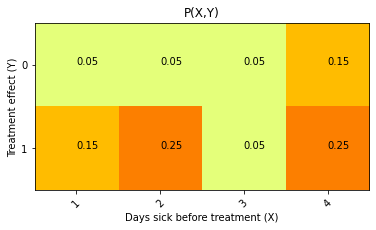

In [52]:
freq = [[0.05,0.05,0.05, 0.15],[0.15,0.25,0.05,0.25]]

plt.clf()
plt.imshow(freq, interpolation='nearest', cmap=plt.cm.Wistia)
X_values = ['1','2','3','4']
Y_values = ['0','1']
plt.ylabel('Treatment effect (Y)')
plt.xlabel('Days sick before treatment (X)') 
plt.title('P(X,Y)') 
plt.xticks(np.arange(len(X_values)), X_values, rotation=45)
plt.yticks(np.arange(len(Y_values)), Y_values)
for i in range(len(X_values)):
    for j in range(len(Y_values)):
        plt.text(i,j, str(freq[j][i]))
plt.show()

Let Y represent the treatment outcome (0 = not recovered, 1 = recovered) and X represent the number of days sick before treatment. Find:

**1) P(Y=1)**



P(Y=1) is equal to:
$$ P(Y=1) = \underset{x=1}{\overset{4}{\sum}}P(X=x, Y=1)$$
$$ P(X=1\cup X=2\cup X=3\cup X=4, Y=1)$$

$$= P(X=1, Y=1) + P(X=2, Y=1) + P(X=3, Y=1) + P(X=4, Y=1)$$
$$= 0.15 + 0.25 + 0.05 + 0.25$$
$$= 0.7$$


In [53]:

prob_Y1 = np.sum(freq[1])
print("P(Y=1) = ",prob_Y1)

P(Y=1) =  0.7


**2) P(Y=1 | X=4)**



$$P(Y=1|X=4)$$ = $$\frac{P(Y=1, X=4)}{P(X=4)}$$
$$ = \frac{P(Y=1, X=4)}{P(Y=0,X=4)+P(Y=1, X=4)}$$
$$= 0.25 / (0.25+0.15)$$
$$= 0.625 $$



In [54]:
freq

[[0.05, 0.05, 0.05, 0.15], [0.15, 0.25, 0.05, 0.25]]

In [55]:
P_Y1_X4 = freq[1][3]
print("P(Y=1, X=4)=", P_Y1_X4)

P_X4 = np.sum(freq, axis=0)[3]
print("P(X=4)=",P_X4)

print("P(Y=1|X=4)=", P_Y1_X4/P_X4)

P(Y=1, X=4)= 0.25
P(X=4)= 0.4
P(Y=1|X=4)= 0.625


**3) P(Y=1 | X<=4)**







$$P(Y=1|X<=4)$$ 
$$= \frac{P(Y=1, X<=4)}{P(X<=4)}$$
$$ = \frac{P(Y=1, X=1 \cup X=2 \cup X=3 \cup X=4)}{\underset{Y}{\sum}P(Y, X<=4)}$$

$$= 0.7 / 1$$
$$= 0.7 $$


In [56]:
freq

[[0.05, 0.05, 0.05, 0.15], [0.15, 0.25, 0.05, 0.25]]

In [57]:
print("prob_Y1_X4 = ", np.sum(freq[1]))
print(np.sum(freq))
print("result =",  np.sum(freq[1])/ (np.sum(freq)))


prob_Y1_X4 =  0.7
1.0
result = 0.7



**4) P(X=4 | Y=1)**



$$P(X=4|Y=1)$$ = $$\frac{P(X=4, Y=1)}{P(Y=1)}$$
$$ = \frac{P( X=4, Y=1)}{P(Y=1,X=0)+P(Y=1,X=1)+P(Y=1,X=2)+P(Y=1,X=3)}$$
$$= 0.25 / (0.25+0.15+0.25+0.05)$$
$$= 0.357 $$



In [58]:
freq

[[0.05, 0.05, 0.05, 0.15], [0.15, 0.25, 0.05, 0.25]]

In [59]:
print(freq[1][3]/ np.sum(freq[1]))

0.35714285714285715


**5) P(X<=4 | Y=0)**;

$$P(X<=4|Y=0)$$ = $$\frac{P(X<=4, Y=0)}{P(Y=0)}$$
$$= \frac{\overset{4}{\underset{x=1}{\sum}}P(X=x,Y=0)}{\overset{4}{\underset{x=1}{\sum}}P(X=x,Y=0)}$$
$$ = \frac{P( X=1 \cup X=2 \cup X=3 \cup X=4, Y=0)}{P(Y=0,X=0)+P(Y=0,X=1)+P(Y=0,X=2)+P(Y=0,X=3)}$$
$$=1$$



In [60]:
freq

[[0.05, 0.05, 0.05, 0.15], [0.15, 0.25, 0.05, 0.25]]

In [61]:
print(np.sum(freq[0]) / np.sum(freq[0]))

1.0


## Exercise 3

A hospital has 5 ambulances, two of them have one bed inside while the rest have two beds inside. Let X = number of two beds ambulances used on any given day and Y = number of one bed ambulances used on any given day.

Suppose the joint probability of X and Y is as follows:

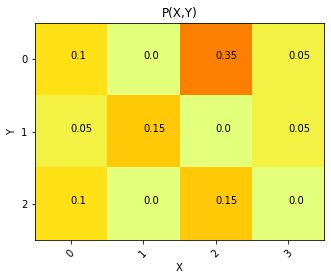

In [66]:
freq = [[0.1,0.0,0.35, 0.05],[0.05,0.15,0.,0.05],[0.10, 0.0, 0.15,0.0]]

plt.clf()
plt.imshow(freq, interpolation='nearest', cmap=plt.cm.Wistia)
X_values = ['0','1','2','3']
Y_values = ['0','1', '2']
plt.ylabel('Y')
plt.xlabel('X') 
plt.title('P(X,Y)') 
plt.xticks(np.arange(len(X_values)), X_values, rotation=45)
plt.yticks(np.arange(len(Y_values)), Y_values)
for i in range(len(X_values)):
    for j in range(len(Y_values)):
        plt.text(i,j, str(freq[j][i]))
plt.show()

Find the probability that, on any given day:

**1) None of the ambulances are hired.**




In this case there is no ambulances get hired, so $X=0$ and $Y=0$ and we need to find $$P(X=0, Y=0)$$
$$= 0.1$$


In [63]:
print("P(X=0, Y=0)", )

P(X=0, Y=0)


**2) All of the one bed ambulances are hired**



$$P(X, Y=2)$$ 
$$={\overset{3}{\underset{x=0}{\sum}}P(X=x,Y=2)}$$
$$=P( X=0,Y=2,) + P( X=1,Y=2) + P(X=2,Y=2) + P(X=3,Y=2)$$
$$0.1+ 0.0+0.15+0.0 = 0.25$$

In [68]:
freq

[[0.1, 0.0, 0.35, 0.05], [0.05, 0.15, 0.0, 0.05], [0.1, 0.0, 0.15, 0.0]]

In [69]:
print("P(X, Y=2) = ", np.sum(freq[2]))


P(X, Y=2) =  0.25


**3) At least 2 of the ambulances are hired.**

At least 2 of the ambulances are hired means that we want to find$P(X+Y)\ge2$. We don't consider the number of beds. 


$$P((X+Y)\ge 2)$$
$$=P(Y=0,X\ge2) + P(Y=1,X\ge1) + P(Y=2, X\ge0)$$
$$=\underset{x=2}{\overset{3}{\sum}}P(Y=0,X=x) + \underset{x=1}{\overset{3}{\sum}}P(Y=1,X=x) + \underset{x=0}{\overset{3}{\sum}}P(Y=2,X=x)$$
$$=(0.35 + 0.05)+(0.15+0+0.05)+(0.1+0+0.15+0)$$
$$= 0.85$$


In [71]:
freq

[[0.1, 0.0, 0.35, 0.05], [0.05, 0.15, 0.0, 0.05], [0.1, 0.0, 0.15, 0.0]]

In [74]:
print("Result =", (freq[0][2] + freq[0][3] )+ freq[1][1] + freq[1][2]+ freq[1][3] + np.sum(freq[2]))


Result = 0.85




**4) All of the one bed ambulances are hired, if all the 2 beds ambulances have been hired.
Compare your answer to (2) and reason whether X and Y are independent.**

This statement equals to $P(Y=2|X=3)$.

Let's compute it:


$$P(Y=2|X=3)$$
$$=\frac{P(X=3, Y=2)}{P(X=3)}$$
$$=\frac{0.0}{P(X=3)}=0$$



## Exercise 4

Let's consider the following data:

(2, 352)


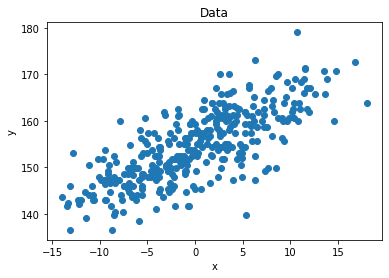

In [84]:
import pandas as pd


data = np.load('./data_exercise4.npy')
print(data.shape)
x = data[0,:] - np.mean(data[0,:])
y = data[1,:]

plt.scatter(x,y)
plt.title('Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

df = pd.DataFrame({'x':x, 'y':y})

According to the plot above, a linear relationship seems to exist between x and y. Therefore, we model the data according to $y_i = \mathcal{N}(\mu_i, \sigma^{2})$ with $\mu_i = a + b*x_i$. We find a posterior distribution for the parameters a, b and $\sigma^{2}$ using a Laplace approximation.

In [85]:
expr = 'y ~ x'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 10
prior_a_sigma = 1
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 1
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 20
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

solution_regression = laplace_solution_regression(expr, df, likelihood, priors)

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/usr/local/lib/python3.8/dist-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 2533.2168549719977
 hess_inv: array([[ 9.17505038e-01,  2.39795129e-02, -4.07301545e-01],
       [ 2.39795129e-02,  1.65664055e-01, -4.79350041e-04],
       [-4.07301545e-01, -4.79350041e-04,  1.39735142e+00]])
      jac: array([  0.46664429,  -4.76559448, -13.81817627])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 93
      nit: 5
     njev: 20
   status: 2
  success: False
        x: array([20.19626306, -0.50929623, 69.73077477])


**1) Examine the posterior distribution for the regression parameters, and decide if the solution is correct or not.**



It is written in the above result that "success: False". It seems solution is not correct. I will do sampling and see the mean/std/CI of the values a, b, sigma

In [95]:
# Sampling:
posterior_samples = posterior_samples = multivariate_normal.rvs(solution_regression[0], solution_regression[1], size = 1000)
#### We compute 85% CI
post_quantiles = np.quantile(posterior_samples, q = [0.075, 0.925], axis = 0)
# Std
post_sd = np.std(posterior_samples, axis = 0)
#Mean
post_mean = np.mean(posterior_samples, axis = 0)
####
summary_stats = [post_mean, post_sd, post_quantiles[0,:],post_quantiles[1,:]]
summary_stats = pd.DataFrame(summary_stats).transpose()
summary_stats.columns = ['mean', 'SD', '2.5%', '97.5%']
summary_stats.rename(index={0:'a',1:'b', 2:'sigma'}, inplace=True)
print(summary_stats, "\n")

            mean        SD       2.5%      97.5%
a      20.150622  0.948932  18.799084  21.509483
b      -0.515062  0.408726  -1.086511   0.070648
sigma  69.706277  1.147965  68.062543  71.325989 



1. The mean of sampled b is -0.51
2. The mean of sampled a is 20.15. Our decleration was 10 which is not good enough. We need to increase the mean of a.

**2) In case there is any problem with the model, modify the code above in order to get a proper solution**

In the class, we see that changing the prior mean and sigma can give us better solutions. Prior parameter a's mean and sigma is very low such that it cannot find a good solution. I will try to increase both mean and sigma to achieve success. 

Also, we can decrease the "sigma_inf" to increase the range of the sigma. Let's try:

In [101]:
expr = 'y ~ x'

# Initializing the likelihood
likelihood = 'gaussian'

# Defining the prior with hyperparameters 
prior_a_mean = 100
prior_a_sigma = 10
prior_a = ['gaussian', [prior_a_mean, prior_a_sigma]]

prior_b_mean = 0
prior_b_sigma = 1
prior_b = ['gaussian', [prior_b_mean, prior_b_sigma]]

sigma_inf = 1
sigma_sup = 50
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

priors = [prior_a, prior_b, prior_sigma]

solution_regression = laplace_solution_regression(expr, df, likelihood, priors)

      fun: 1094.3664943446927
 hess_inv: array([[ 4.54652791e-02, -9.56016015e-05, -1.24321412e-02],
       [-9.56016015e-05,  1.71813580e-03,  1.81371433e-05],
       [-1.24321412e-02,  1.81371433e-05,  1.26235714e-02]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 136
      nit: 25
     njev: 34
   status: 0
  success: True
        x: array([154.55721963,   0.9034408 ,   5.07203294])


With our new declerations, we succed.

## Exercise 5

Consider the following function on the interval [0, 3]:

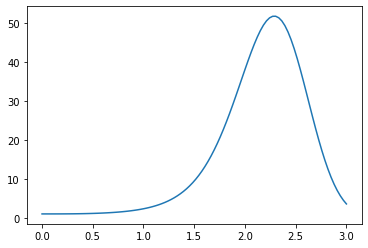

In [78]:
x = np.linspace(0., 3., 100)

# f = exp(x^2 sin(x))
f = np.exp(x**2*np.sin(x))

plt.plot(x, f)
plt.show()

**1) Approximate this function using the Laplace approximation.**



Let's find the Laplace approximation for the model $f(x) = exp(x*sin(x))$.

1- We take logarithm:

$$g(\theta)  = \log(f) = \theta*sin(\theta)$$


2- Find the maximum of the log-distribution. we derive with respect to $\theta$ and solve:

I found the derivative of the  $\theta*sin(\theta)$ on the internet
$$\frac{\delta g}{\delta \theta} = sin(\theta) + \theta*cos(\theta) $$

3- Then make it equal to zero and extract $\theta$:

$g'(\theta_0) = 0$
I used internet again to find the $\theta$ values that makes the first derivative zero. So, 

$\theta_0$ = \{-2, 0, 2\}

Our function is defines above between 0 and 3. So we need to take $$\theta_0 = 2$$.

4- We compute the second derivative:


$$g''(\theta) = 2*cos(\theta) - \theta*sin(\theta)$$

5- Write the distirbution. The distribution is a Gaussian distribution with mean $\theta_0$, and variance $-\frac{1}{g''(\theta_0)}$.

So,

$$N(2, \frac{1}{2*cos(2) - 2*sin(2)}\big)$$













**2) Plot the original function and your approximation on the same graph.**

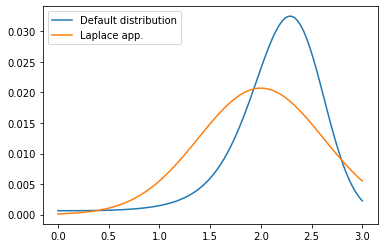

In [80]:

theta_0 = 2
hessian  = (2*np.cos(2)-2*np.sin(2))
variance  = -1/hessian
our_distribution = norm(theta_0, np.sqrt(variance))

plt.figure()
plt.plot(x, f/np.sum(f), 
label="Default distribution")
plt.plot(x, our_distribution.pdf(x)/np.sum(our_distribution.pdf(x)), label="Laplace app.")
plt.legend()
plt.show()

## Exercise 6

From the file grades.csv we are interested in predicting the final evaluation score from the midterm one. 

- (6.1) Find appropriate priors for a linear model. Sample from the priors to verify that the choice of all the priors parameters is compatible with the regression problem




In [103]:
data = pd.read_csv("grades.csv", sep=",")
data.describe()

,student,midterm,final
count,52.000000,52.000000,52.000000
mean,26.500000,78.596154,119.807692
std,15.154757,9.632990,16.102659
min,1.000000,53.000000,78.000000
25%,13.750000,71.000000,115.500000
50%,26.500000,79.000000,122.000000
75%,39.250000,88.000000,130.250000
max,52.000000,96.000000,145.000000


In [106]:

mu = 40
sigma = 20 

a = 0
b = 40
mu0 = 78
tau = 10
n_samples = 1000

# Initializing the likelihood
likelihood = 'gaussian'
parameters = [mu, sigma]

# Defining the prior with hyperparameters 
prior_mu_mean = mu0
prior_mu_sigma = tau
prior_mu = ['gaussian', [prior_mu_mean, prior_mu_sigma]]

sigma_inf = a
sigma_sup = b
prior_sigma_unif = [sigma_inf, sigma_sup]
prior_sigma = ['uniform', prior_sigma_unif]

solution = laplace_solution([mu,sigma], [], data["midterm"], likelihood, [prior_mu, prior_sigma])

      fun: 197.98215316733427
 hess_inv: array([[1.6838178 , 0.01086516],
       [0.01086516, 0.87032445]])
      jac: array([ 1.90734863e-06, -1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 17
     njev: 20
   status: 0
  success: True
        x: array([78.58590526,  9.53992225])


- (6.2) Fit a regression model using these priors (you can use either your Laplace implementation or Stan)
- (6.3) Sample from the posterior and plot the related regression function. Is this simulation compatible with the observations?
- (6.4) Compute the standard deviation for the final score of a student with midterm score of 44.
- (6.5) Fit a quadratic model and compare it to the linear one for this regression problem. Which model would you prefer? Why?

# Exercise 7

Implement the Metropolis-Hastings algorithm to estimate the posterior distribution for the parameter of a Binomial model with prior *Beta(2,3)*. Assume 40 observations with 10 successes and 30 fails.

In [105]:
!pip3 install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import stan
#import nest_asyncio as asyncio
import nest_asyncio
nest_asyncio.apply()

In [ ]:
binomial_model_code_2 = """
data {
  int<lower=1> N;
  int y[N];
  real x[N];
}
parameters {
  real a;
  real b;

}
transformed parameters {
  vector[N] p_i;
  for (i in 1:N) {
    p_i[i] = exp(a + b * x[i] )/(1 + exp(a + b * x[i] )); 
    }
}
model {
  b ~ normal(0, 3);
  a ~ normal(0, 3);
  y ~ binomial(1, p_i);
}
"""